In [1]:
import tensorflow as tf
print(tf.__version__)

2025-11-27 00:02:39.975081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 00:02:40.047154: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-27 00:02:41.393857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
# 01 Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

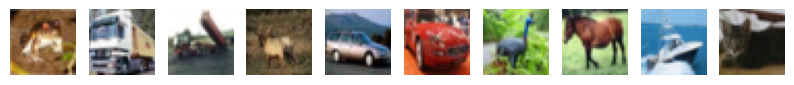

In [3]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [4]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [5]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3),
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [6]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764223383.462814  132840 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 28, 28, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │        12,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,514 (56.70 KB)

 Trainable params: 14,514 (56.70 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

2025-11-27 00:03:19.498634: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f9df0003c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-27 00:03:19.498661: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-11-27 00:03:19.507899: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-27 00:03:19.537596: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-27 00:03:19.551314: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-27 00:03:19.

accuracy: 0.089


#### Train model with checkpoints

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_filepath = '01_checkpoints/best_model.h5'

# Create the folder if it does not exist
import os
os.makedirs(os.path.dirname(checkpoint_filepath), exist_ok=True)

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [13]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x=x_train, y=y_train,
          epochs=3,
          callbacks=[model_checkpoint_callback])

Epoch 1/3
300/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5092 - loss: 1.3598

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5080 - loss: 1.3649
Epoch 2/3
306/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5323 - loss: 1.3087

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5301 - loss: 1.3114
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5453 - loss: 1.2699

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5481 - loss: 1.2705


In [14]:
# Have a look at what the checkpoint creates

!ls -lh checkpoints/best_model.h5

-rw-r--r-- 1 nvidia nvidia 209K Nov 27 00:06 checkpoints/best_model.h5


In [15]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.521


#### Create new model, load weights

In [16]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model2 = get_new_model()
get_test_accuracy(model2, x_test, y_test)

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


accuracy: 0.095


In [18]:
# Load weights -- accuracy is the same as the trained model

model2.load_weights(checkpoint_filepath)
get_test_accuracy(model2, x_test, y_test)
print("Hooray! We have successfully saved and loaded a model.")

accuracy: 0.521
Hooray! We have successfully saved and loaded a model.


#### Clear directory

In [ ]:
! rm -r model_checkpoints

***
# 02 Explanation of saved files

***
<a id="coding_tutorial_2"></a>
# 03 Model saving criteria

#### Create more customised checkpoint

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [40]:
checkpoint_epoch_path = (
    '03_01_checkpoints_epoch_batch/'
    'model_epoch-{epoch:02d}_val_accuracy-{val_accuracy:.4f}.keras'
)

model_checkpoint_epoch_cb = ModelCheckpoint(
    filepath=checkpoint_epoch_path,
    save_weights_only=False,
    save_freq='epoch',      # <--- important
    monitor='val_accuracy',
    mode='max',
    save_best_only=True     # usually what you want with val metrics
)

model3 = get_new_model()
model3.fit(
    x=x_train, y=y_train,
    epochs=3,
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=[model_checkpoint_epoch_cb]
)


Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.2736 - loss: 1.9414 - val_accuracy: 0.3670 - val_loss: 1.7301
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.4158 - loss: 1.6198 - val_accuracy: 0.4570 - val_loss: 1.5570
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4629 - loss: 1.4881 - val_accuracy: 0.4730 - val_loss: 1.4871


In [42]:
# Have a look at what the checkpoint creates

!ls -lh checkpoints_epoch_batch

total 624K
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:25 model_epoch-01_val_accuracy-0.3670.keras
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:25 model_epoch-02_val_accuracy-0.4570.keras
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:25 model_epoch-03_val_accuracy-0.4730.keras


#### Work with model saving criteria

In [43]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [44]:
# Create a new instance of untrained model

model4 = get_new_model()

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = (
    '03_02_checkpoints_best_only/'
    'best_model_val_accuracy-{val_accuracy:.4f}.keras'
)

model_checkpoint_best_cb = ModelCheckpoint(
    filepath=checkpoint_best_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch'      # <--- important
)

In [49]:
# Fit the model and save only the weights with the highest validation accuracy

history = model4.fit(
    x=x_train, y=y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    batch_size=32,
    callbacks=[model_checkpoint_best_cb]
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1600 - loss: 2.3123 - val_accuracy: 0.0600 - val_loss: 2.3435
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1600 - loss: 2.2632 - val_accuracy: 0.0600 - val_loss: 2.3300
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1500 - loss: 2.2511 - val_accuracy: 0.0600 - val_loss: 2.3309
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1600 - loss: 2.2366 - val_accuracy: 0.0600 - val_loss: 2.3462
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1600 - loss: 2.2281 - val_accuracy: 0.0600 - val_loss: 2.3796
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1600 - loss: 2.2133 - val_accuracy: 0.0600 - val_loss: 2.3615
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1600 - loss: 2.2006 - val_accuracy: 0.0600 - val_loss: 2.3448
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1600 - loss: 2.1889 - val_accuracy: 0.0600 - val_loss: 2.3488
Ep

It only saves the model at the end of each epoch, if the validation accuracy improved compared to previous epochs.

<Axes: >

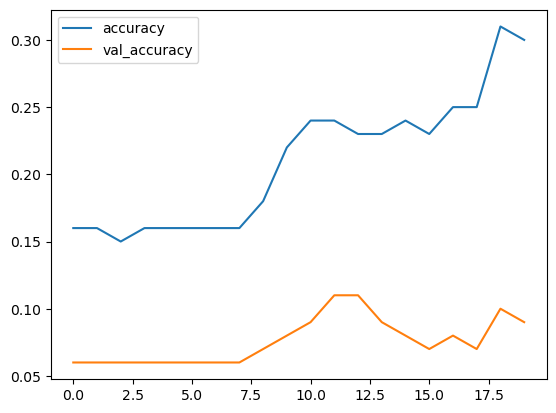

In [50]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [52]:
# Inspect the checkpoint directory

!ls -lh 03_02_checkpoints_best_only/

total 1.1M
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:31 best_model_val_accuracy-0.0600.keras
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:31 best_model_val_accuracy-0.0700.keras
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:31 best_model_val_accuracy-0.0800.keras
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:31 best_model_val_accuracy-0.0900.keras
-rw-r--r-- 1 nvidia nvidia 205K Nov 27 00:31 best_model_val_accuracy-0.1100.keras


In [57]:
# Create a new model with the saved weights

model5 = get_new_model()

# get the name the folder with the best weights
best_acc = 0
for fname in os.listdir('03_02_checkpoints_best_only/'):
    acc = fname.split('-')[1].replace('.keras', '')
    if float(acc) > float(best_acc):
        best_fname = fname
        best_acc = acc
print(f'Best model file: {best_fname} with accuracy {best_acc}')

Best model file: best_model_val_accuracy-0.1100.keras with accuracy 0.1100


/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [60]:
model5.load_weights(f'03_02_checkpoints_best_only/{best_fname}')
get_test_accuracy(model5, x_test, y_test)

accuracy: 0.110


/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


#### Clear directory

In [ ]:
# ! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
# 04 Loadinng the entire model, not just weights

#### Create checkpoint that saves whole model, not just weights... I did that the whole notebook

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [63]:
# Create Tensorflow checkpoint object

new_model = load_model('03_02_checkpoints_best_only/best_model_val_accuracy-0.1100.keras')
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.110


***
# 05 Saving only the arhitecture of the model (?)

***
<a id="coding_tutorial_4"></a>
# 06 Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [67]:
from tensorflow.keras.applications import ResNet50
resnet50 = ResNet50(weights='imagenet') # imagenet pre-trained weights, to find the imagenet classes go to https://github.com/anishathalye/imagenet-simple-labels

In [68]:
resnet50.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_20[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

#### Import and preprocess 3 sample images

In [ ]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [43]:
# move all the images into the imgs folder
!mkdir -p 06_imgs
!mv lemon.jpg 06_imgs/
!mv viaduct.jpg 06_imgs/
!mv water_tower.jpg 06_imgs/

In [69]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224)) # 224x224 is the required size for ResNet50
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [70]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(resnet50.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2]
    return top_preds

##### Image 1: lemon

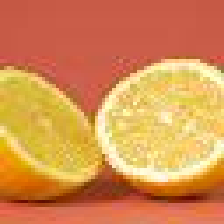

In [73]:
# Display image

lemon_img

In [72]:
# Display top 5 predictions

get_top_5_predictions(lemon_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


,prediction,probability
1,consomme,0.237024
2,eggnog,0.226445
3,lemon,0.199245
4,face_powder,0.030616
5,ladle,0.030463


##### Image 2: viaduct

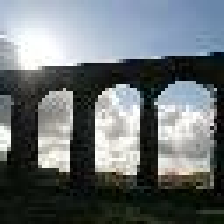

In [74]:
# Display image

viaduct_img

In [75]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


,prediction,probability
1,vault,0.433343
2,viaduct,0.113697
3,prison,0.107941
4,window_screen,0.067969
5,megalith,0.016879


##### Image 3: water tower

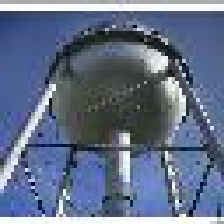

In [76]:
# Display image

water_tower_img

In [79]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


,prediction,probability
1,solar_dish,0.483398
2,ladle,0.165664
3,planetarium,0.101559
4,strainer,0.052492
5,jigsaw_puzzle,0.02385


***
<a id="coding_tutorial_5"></a>
# 07 Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [ ]:
# !pip install --upgrade pip
# !pip install tensorflow-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorflow-hub]m [tensorflow-hub]


In [1]:
import tensorflow_hub as hub

2025-11-27 01:13:23.811217: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 01:13:23.832231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764227603.860673  150518 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764227603.867172  150518 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764227603.881388  150518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [13]:
import tensorflow_hub as hub
hub.KerasLayer("https://kaggle.com/models/google/mobilenet-v1/TensorFlow2/050-160-classification/1",
               trainable=True, arguments=dict(batch_norm_momentum=0.997))


In [11]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

ValueError: Only instances of `keras.Layer` can be added to a Sequential model. Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x79eb941c8620> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [14]:
import tensorflow as tf
import tensorflow_hub as hub

handle = (
    "https://kaggle.com/models/google/mobilenet-v1/"
    "TensorFlow2/050-160-classification/1?tfhub-redirect=true"
)

# Create the TF Hub layer normally
hub_layer = hub.KerasLayer(handle)

# Wrap it in a Lambda layer so Keras sees a proper keras.Layer
model = tf.keras.Sequential([
    tf.keras.layers.Lambda(
        lambda x: hub_layer(x),
        input_shape=(160, 160, 3)  # (H, W, C) for this MobileNet variant
    )
])

# Optional: check it runs
model.summary()
x_dummy = tf.random.uniform((1, 160, 160, 3))
y_dummy = model(x_dummy)
print(y_dummy.shape)

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 1001)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1764228209.726965  150686 cuda_dnn.cc:529] Loaded cuDNN version 91600


(1, 1001)


In [15]:
import tensorflow as tf
import tensorflow_hub as hub
import tf_keras as keras  # compatibility wrapper for tf.keras

mobilenet_url = (
    "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/5"
    # equivalent to the Kaggle redirect you used
)

m = keras.Sequential([
    hub.KerasLayer(mobilenet_url)
])
m.build([None, 160, 160, 3])
m.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1001)              1343049   
                                                                 
Total params: 1343049 (5.12 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1343049 (5.12 MB)
_________________________________________________________________


#### Use MobileNet model to classify images

In [17]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("water_tower.jpg", target_size=(160, 160))

In [21]:
!mkdir -p 07_data
!wget -O 07_data/imagenet_categories.txt \
  https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt


--2025-11-27 01:33:26--  https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 192.178.56.187, 192.178.56.219, 192.178.56.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|192.178.56.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10484 (10K) [text/plain]
Saving to: ‘data/imagenet_categories.txt’

data/imagenet_categ 100%[===================>]  10.24K  --.-KB/s    in 0.002s  

2025-11-27 01:33:26 (5.18 MB/s) - ‘data/imagenet_categories.txt’ saved [10484/10484]



In [ ]:
# Read in categories text file

with open('07_data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [37]:
# Useful function: presents top 5 predictions

import pandas as pd

# image to array import
from tensorflow.keras.preprocessing.image import img_to_array

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
        top_preds.loc[i+1, 'logit'] = preds[0][sorted_index[i]]
    return top_preds

##### Image 1: lemon

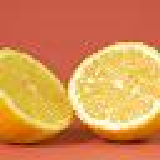

In [34]:
lemon_img

In [38]:
get_top_5_predictions(lemon_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,prediction,logit
1,shower cap,12.381910
2,tray,9.896068
3,Petri dish,9.484809
4,candle,9.428556
5,brassiere,9.361268


##### Image 2: viaduct

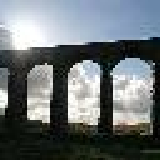

In [29]:
viaduct_img

In [39]:
get_top_5_predictions(viaduct_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


,prediction,logit
1,viaduct,11.529356
2,dam,9.739491
3,pier,9.631786
4,monastery,9.596604
5,prison,9.549198


##### Image 3: water tower

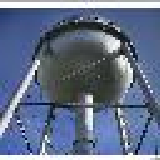

In [32]:
water_tower_img

In [40]:
get_top_5_predictions(water_tower_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


,prediction,logit
1,solar dish,9.425880
2,water tower,9.167045
3,jigsaw puzzle,8.502974
4,castle,8.335670
5,aircraft carrier,8.274899


# 08 Playing with other models

https://www.kaggle.com/models/google/gemma/keras

In [83]:
!pip install -U keras-hub
!pip install -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 47.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 20.7 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 16.9 MB/s  0:00:38m0:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 58.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.8 MB/s  0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.1
    Uninstalling protobuf-6.33.1:
      Successfully uninstalled protobuf-6.33.1
  Attempting uninstall: numpy90m━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/8 [protobuf]
    Found existing installation: numpy 2.2.6━━━━━━━━━━━━━━━━━━ 1/8 [protobuf]
    Uninstalling numpy-2.2.6:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/8 [numpy]
      Successfully uninstalled numpy-2.2.6━━━━━━━━━━━━━━━━━━━━ 2/8 [numpy]
  Attempting uninstall: tensorboard0m━━━

In [84]:
import keras
import keras_hub
import numpy as np

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [85]:
gemma_lm = keras_hub.models.GemmaCausalLM.from_preset("gemma_1.1_instruct_2b_en")
gemma_lm.generate("Keras is a", max_length=30)

# Generate with batched prompts.
gemma_lm.generate(["Keras is a", "I want to say"], max_length=30)

ValueError: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/models/keras/gemma/keras/gemma_1.1_instruct_2b_en/4. The server reported the following issues: Permission denied on resource (or it may not exists).
Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.

In [7]:
import keras
import keras_hub
import numpy as np

/home/nvidia/miniforge3/envs/rapids-25.10-cuda12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
gemma_lm = keras_hub.models.GemmaCausalLM.from_preset("gemma_1.1_instruct_2b_en")
gemma_lm.generate("Keras is a", max_length=30)

# Generate with batched prompts.
gemma_lm.generate(["Keras is a", "I want to say"], max_length=30)


ValueError: 403 Client Error.

You don't have permission to access resource at URL: https://www.kaggle.com/models/keras/gemma/keras/gemma_1.1_instruct_2b_en/4. The server reported the following issues: Permission denied on resource (or it may not exists).
Please make sure you are authenticated if you are trying to access a private resource or a resource requiring consent.